Let's proceed with the re-QC process of PennCNV, following our findings from yesterday.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
# figure out who is who in each trio
import glob
data_dir = '/data/sudregp/cnv/penncnv/'
ped_file = '/data/sudregp/cnv/simplex.ped'
wes_prefix = ['CLIA', 'CCGO', 'WPS']
trios = []
affected = []
controls = []
samples = []
famids = []
fid = open(ped_file, 'r')
for line in fid:
    famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
    if fa[:4] in wes_prefix and mo[:4] in wes_prefix and sid[:4] in wes_prefix:
        fam = {}
        fam['child'] = sid
        if aff == '1':
            affected.append(sid)
        else:
            controls.append(sid)
        fam['father'] = fa
        fam['mother'] = mo
        fam['famid'] = famid
        trios.append(fam)
        samples += [sid, fa, mo]
        famids.append(famid)
fid.close()
samples = set(samples)
famids = set(famids)

In [9]:
df = pd.read_table('/data/sudregp/cnv/penncnv/results/all_simplex.qcsum')
# we ran for all samples, but let's look at only stats for samples in our simplex study
keep_me = [i for i in range(df.shape[0]) if df.File[i].split('/')[-1] in samples]
df = df.iloc[keep_me]

# now, for each trio I get the name of the kid and then the parents, and 
# update the NumCNV count in the dataframe
members = ['father', 'mother', 'child']
for trio in trios:
    fname = '/data/sudregp/cnv/penncnv/results/%s.jointcnv' % trio['child']
    fid = open(fname, 'r')
    counts = {}
    for m in members:
        counts[m] = 0
    for line in fid:
        for m in members:
            if line.find(trio[m]) > 0:
                counts[m] += 1
    for m in members:
        frow = [f for f in df.File if f.split('/')[-1] == trio[m]][0]
        df.loc[df.File == frow, 'NumCNV'] = counts[m]
df.head()
        

,File,LRR_mean,LRR_median,LRR_SD,BAF_mean,BAF_median,BAF_SD,BAF_drift,WF,NumCNV
1,InfiniumExome/CLIA_400149,-0.0550,0.0,0.3398,0.5041,0.5,0.0555,0.000391,0.0940,752
2,InfiniumExome/CLIA_400190,0.0081,0.0,0.1328,0.5002,0.5,0.0351,0.000000,-0.0160,106
3,InfiniumExome/CLIA_400186,0.0172,0.0,0.1504,0.4993,0.5,0.0383,0.000084,-0.0186,106
4,InfiniumExome/CLIA_400140,0.0022,0.0,0.1338,0.4991,0.5,0.0362,0.000000,-0.0293,198
6,InfiniumExome/CLIA_400138,0.0136,0.0,0.1353,0.4989,0.5,0.0343,0.000121,0.0204,136


Now we can go ahead and replot the QC metrics:

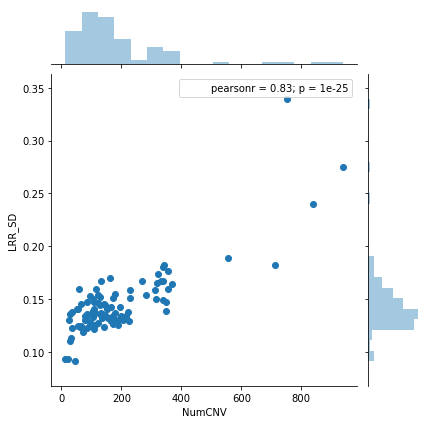

In [10]:
sns.jointplot(x='NumCNV', y='LRR_SD', data=df)

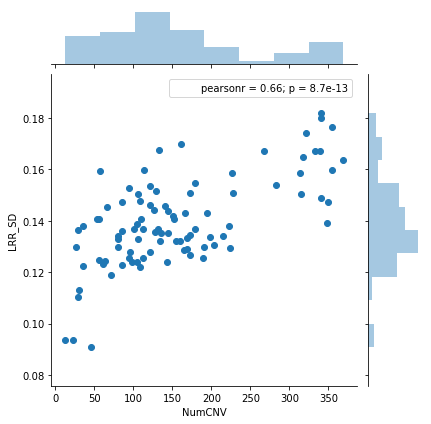

In [11]:
sns.jointplot(x='NumCNV', y='LRR_SD', data=df[df.NumCNV <= 400])

OK, so I can have a reasonable cut-off at 400 CNVs, and then a more conservative one at 250. These number seem quite high, and they're indeed higher than what we get when doing just raw cnvs. But let's go with it anyways, as it seems to be the preferred way to do it when we have family relationship. It's also supposed to be better and newer, but slow (http://penncnv.openbioinformatics.org/en/latest/user-guide/joint/).

In [12]:
df400 = df[df.NumCNV <= 400]
df250 = df[df.NumCNV <= 250]

In [14]:
fid = open('/data/sudregp/cnv/penncnv/good_kids_joint_numCNVse400.txt', 'w')
for f in df400.File:
    sample = f.split('/')[-1]
    # control and affected only include kids!
    if sample in controls + affected:
        fid.write(sample + '\n')
fid.close()

fid = open('/data/sudregp/cnv/penncnv/good_kids_joint_numCNVse250.txt', 'w')
for f in df250.File:
    sample = f.split('/')[-1]
    # control and affected only include kids!
    if sample in controls + affected:
        fid.write(sample + '\n')
fid.close()

In [15]:
%%bash
cd /data/sudregp/cnv/penncnv/results

echo "kid,denovo,inherited" > summary_called.csv;
while read sample; do
    triocnv=${sample}'.jointcnv'
    rm denovo.txt inherited.txt 2>/dev/null
    grep mother ${triocnv} > mom_snps;
    grep father ${triocnv} > dad_snps;
    cat mom_snps dad_snps > parent_snps;
    for snp in `grep offspring ${triocnv} | cut -d' ' -f 1`; do
        if ! grep -q $snp parent_snps; then
            echo "$snp" >> denovo.txt
        else
            echo "$snp" >> inherited.txt
        fi;
   done
   echo ${sample},`cat denovo.txt 2>/dev/null | wc -l`,`cat inherited.txt 2>/dev/null | wc -l` >> summary_called.csv;
   rm *_snps;
done < ../good_kids_joint_numCNVse400.txt

In [16]:
def plot_cnvs(fname, t_str):
    import plotly.graph_objs as go
    from plotly import tools

    df = pd.read_csv(fname)
    df['total'] = df.denovo + df.inherited

    fig = tools.make_subplots(rows=3, cols=1, subplot_titles=('De Novo CNVs',
                                                              'Inherited CNVs',
                                                              'All CNVs'))

    for c, cnv in enumerate(['denovo', 'inherited', 'total']):
        x_red, x_green, red, green, xticks = [], [], [], [], []
        red_text, green_text = [], []

        # loop through families
        f = 0
        for fam in famids:
            fam_kids = [t['child'] for t in trios if t['famid'] == fam]
            found = False
            for kid in fam_kids:
                if kid in list(df.kid):
                    found = True
                    if kid in affected:
                        red.append(int(df[df.kid == kid][cnv]))
                        x_red.append(f)
                        red_text.append(kid)
                    else:
                        green.append(int(df[df.kid == kid][cnv]))
                        x_green.append(f)
                        green_text.append(kid)
            # only increase counter if we added a kid
            if found:
                xticks.append(fam)
                f += 1


        trace0 = go.Scatter(
            x = x_red,
            y = red,
            mode = 'markers',
            name = 'affected',
            marker = dict(size = 10, color = 'red'),
            text = red_text,
            hoverinfo='text+y',
            showlegend = False
        )
        trace1 = go.Scatter(
            x = x_green,
            y = green,
            mode = 'markers',
            name = 'unaffected',
            marker = dict(size = 10, color = 'green'),
            hovertext = green_text,
            hoverinfo='text+y',
            showlegend = False
        )
        fig.append_trace(trace0, c + 1, 1)
        fig.append_trace(trace1, c + 1, 1)

    fig['layout'].update(height=900, width=800, title=t_str,
                         xaxis1=dict(tickvals=range(len(xticks)),
                                    ticktext=xticks,
                                    zeroline = False),
                         xaxis2=dict(tickvals=range(len(xticks)),
                                    ticktext=xticks,
                                    zeroline = False),
                         xaxis3=dict(tickvals=range(len(xticks)),
                                    ticktext=xticks,
                                    zeroline = False),
                         hovermode='closest')
    fig['data'][0]['showlegend'] = True
    fig['data'][1]['showlegend'] = True
    iplot(fig)

In [17]:
plot_cnvs('/data/sudregp/cnv/penncnv/results/summary_called.csv',
          'All called (numCNV <= 400)')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



Not much to see there. If anything, it appears that the cNVs would be protective. Let's look at some other sets of CNVs, including some annnotated schemes.

In [19]:
%%bash
cd /data/sudregp/cnv/penncnv/results

echo "kid,denovo,inherited" > summary_called_250.csv;
while read sample; do
    triocnv=${sample}'.jointcnv'
    rm denovo.txt inherited.txt 2>/dev/null
    grep mother ${triocnv} > mom_snps;
    grep father ${triocnv} > dad_snps;
    cat mom_snps dad_snps > parent_snps;
    for snp in `grep offspring ${triocnv} | cut -d' ' -f 1`; do
        if ! grep -q $snp parent_snps; then
            echo "$snp" >> denovo.txt
        else
            echo "$snp" >> inherited.txt
        fi;
   done
   echo ${sample},`cat denovo.txt 2>/dev/null | wc -l`,`cat inherited.txt 2>/dev/null | wc -l` >> summary_called_250.csv;
   rm *_snps;
done < ../good_kids_joint_numCNVse250.txt

In [20]:
plot_cnvs('/data/sudregp/cnv/penncnv/results/summary_called_250.csv',
          'All called (numCNV <= 250)')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



It cuts down some of the outliers, but still not much pattern there. Let's focus on annotated variants only according to refGene:

In [21]:
%%bash

module load penncnv
cd /data/sudregp/cnv/penncnv/results

while read sample; do
    cnv=${sample}'.jointcnv'
    gene=/fdb/annovar/current/hg19/hg19_refGene.txt
    link=/fdb/annovar/current/hg19/hg19_refLink.txt

    # there are some differences in the files...
    scan_region.pl ${cnv} $gene -refexon -reflink $link > ${cnv}_refexon
    scan_region.pl ${cnv} $gene -refgene -reflink $link > ${cnv}_refgene

    gene=/fdb/annovar/current/hg19/hg19_knownGene.txt
    link=/fdb/annovar/current/hg19/hg19_kgXref.txt
    scan_region.pl ${cnv} $gene -knowngene -kgxref $link > ${cnv}_knowngene
done < ../good_kids_joint_numCNVse400.txt


In [28]:
%%bash
cd /data/sudregp/cnv/penncnv/results

filter=refgene
for qc in 250 400; do
    echo "kid,denovo,inherited" > summary_${filter}_${qc}.csv;
    while read sample; do
        triocnv=${sample}'.jointcnv_'${filter}
        rm denovo.txt inherited.txt 2>/dev/null
        grep mother ${triocnv} > mom_snps;
        grep father ${triocnv} > dad_snps;
        cat mom_snps dad_snps | grep -v NOT_FOUND > parent_snps;
        for snp in `grep offspring ${triocnv} | grep -v NOT_FOUND | cut -d' ' -f 1`; do
            if ! grep -q $snp parent_snps; then
                echo "$snp" >> denovo.txt
            else
                echo "$snp" >> inherited.txt
            fi;
       done
       echo ${sample},`cat denovo.txt 2>/dev/null | wc -l`,`cat inherited.txt 2>/dev/null | wc -l` >> summary_${filter}_${qc}.csv;
       rm *_snps;
    done < ../good_kids_joint_numCNVse${qc}.txt;
done

In [29]:
plot_cnvs('/data/sudregp/cnv/penncnv/results/summary_refgene_400.csv',
          'In refGene DB (numCNV <= 400)')
plot_cnvs('/data/sudregp/cnv/penncnv/results/summary_refgene_250.csv',
          'In refGene DB (numCNV <= 250)')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



Then, we look at the ones annotated by exon instead:

In [30]:
%%bash
cd /data/sudregp/cnv/penncnv/results

filter=refexon
for qc in 250 400; do
    echo "kid,denovo,inherited" > summary_${filter}_${qc}.csv;
    while read sample; do
        triocnv=${sample}'.jointcnv_'${filter}
        rm denovo.txt inherited.txt 2>/dev/null
        grep mother ${triocnv} > mom_snps;
        grep father ${triocnv} > dad_snps;
        cat mom_snps dad_snps | grep -v NOT_FOUND > parent_snps;
        for snp in `grep offspring ${triocnv} | grep -v NOT_FOUND | cut -d' ' -f 1`; do
            if ! grep -q $snp parent_snps; then
                echo "$snp" >> denovo.txt
            else
                echo "$snp" >> inherited.txt
            fi;
       done
       echo ${sample},`cat denovo.txt 2>/dev/null | wc -l`,`cat inherited.txt 2>/dev/null | wc -l` >> summary_${filter}_${qc}.csv;
       rm *_snps;
    done < ../good_kids_joint_numCNVse${qc}.txt;
done

In [33]:
plot_cnvs('/data/sudregp/cnv/penncnv/results/summary_refexon_400.csv',
          'In refExon DB (numCNV <= 400)')
plot_cnvs('/data/sudregp/cnv/penncnv/results/summary_refexon_250.csv',
          'In refExon DB (numCNV <= 250)')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



And finally the ones annotated using knownGene:

In [32]:
%%bash
cd /data/sudregp/cnv/penncnv/results

filter=knowngene
for qc in 250 400; do
    echo "kid,denovo,inherited" > summary_${filter}_${qc}.csv;
    while read sample; do
        triocnv=${sample}'.jointcnv_'${filter}
        rm denovo.txt inherited.txt 2>/dev/null
        grep mother ${triocnv} > mom_snps;
        grep father ${triocnv} > dad_snps;
        cat mom_snps dad_snps | grep -v NOT_FOUND > parent_snps;
        for snp in `grep offspring ${triocnv} | grep -v NOT_FOUND | cut -d' ' -f 1`; do
            if ! grep -q $snp parent_snps; then
                echo "$snp" >> denovo.txt
            else
                echo "$snp" >> inherited.txt
            fi;
       done
       echo ${sample},`cat denovo.txt 2>/dev/null | wc -l`,`cat inherited.txt 2>/dev/null | wc -l` >> summary_${filter}_${qc}.csv;
       rm *_snps;
    done < ../good_kids_joint_numCNVse${qc}.txt;
done

In [34]:
plot_cnvs('/data/sudregp/cnv/penncnv/results/summary_knowngene_400.csv',
          'In knownGene DB (numCNV <= 400)')
plot_cnvs('/data/sudregp/cnv/penncnv/results/summary_knowngene_250.csv',
          'In knownGene DB (numCNV <= 250)')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



So, not much difference among the different filters. Expected, as these are SNPs in an exome chip. 

What do we get if we only look at CNVs expressed in the Allen Brain atlas? I got a list from the UCSC browser website containing 606 genes expressed in the Allen Brain Atlas. They're part of a larger set of files, but I couldn't get those annotations to work with PennCNV. I could spend more time on it, but it's better just to grep our previously annotated databases to that list, and do more analysis later if necessary.

In [36]:
%%bash
cd /data/sudregp/cnv/penncnv/results

for qc in 250 400; do
    echo "kid,denovo,inherited" > summary_brain_${qc}.csv;
    while read sample; do
        triocnv=${sample}'.jointcnv_knowngene'
        rm denovo.txt inherited.txt 2>/dev/null
        grep mother ${triocnv} > mom_snps;
        grep father ${triocnv} > dad_snps;
        cat mom_snps dad_snps | grep -f ../hg19_allenBrainGene_trimmed.txt > parent_snps;
        for snp in `grep offspring ${triocnv} | grep -f ../hg19_allenBrainGene_trimmed.txt | cut -d' ' -f 1`; do
            if ! grep -q $snp parent_snps; then
                echo "$snp" >> denovo.txt
            else
                echo "$snp" >> inherited.txt
            fi;
       done
       echo ${sample},`cat denovo.txt 2>/dev/null | wc -l`,`cat inherited.txt 2>/dev/null | wc -l` >> summary_brain_${qc}.csv;
       rm *_snps;
    done < ../good_kids_joint_numCNVse${qc}.txt;
done

In [37]:
for qc in [400, 250]:
    plot_cnvs('/data/sudregp/cnv/penncnv/results/summary_brain_%d.csv' % qc,
              'In Allen Brain Atlas (knowGene, numCNV <= %d)' % qc)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This reduces our CNV numbers by quite a bit, which is expected and to a certain extent wanted. There are some interesting things in there to look further, such as whether it's the same genes "protecting" the controls, or "disrupting" the ADHD kid. But let's keep on looking...

We can also try to look at only the CNVs known in the literature to affect ADHD. A few important papers to look at:
 * http://orca.cf.ac.uk/30259/1/Williams%202012.pdf
 * http://orca.cf.ac.uk/61654/1/WOA-20132014-10.pdf
 * http://orca.cf.ac.uk/49622/1/Thapar%202013.pdf
 * https://ajp.psychiatryonline.org/doi/pdf/10.1176/appi.ajp.2011.11040551
 * http://www.thelancet.com/pdfs/journals/lancet/PIIS0140-6736(10)61109-9.pdf
 
 Because of the uniqueness of our sample, it would be nice to explore it agnostic of those findings, and then just use them for confirmation (or not). But at the same time, it would be nice to have a bridge between what they have found and what we see.
 
 In any case, these are the key findings:
 * ADHD shows enrichment of large (> 100Kb, but > 500 Kb show greatest enrichment), rare CNVs (< 1% population frequency) in comparison to controls (2012)
 * Duplications at 15q13.3 (CHRNA7 gene) can be a novel risk factor for ADHD (2012)
 * ADHD and ASD share CNVs (2014), and also SCZ (lancet)
 * excess of chromosome 16p13.11 duplications was noted in the ADHD group (lancet)
 
But reading those papers is hard to come up with a list of specific CNVs to look for, as CNVs are not constant across samples. We could go by general position (see ch16 or 15 above). It's clear that the comparisons work for total CNV burden, and also duplication, but not as strongly for deletion, so that's a start. We could also do some more cleaning, like what's described below. 

# Stricter preprocessing pipeline

Let's follow a siilar pre-processing pipeline as what was done in the Thapar papers. With a few modification, though. For example, we can't compute rare CNVs in our sample, at least not at that rate, as we don't even have 100 subjects. I might also need to play with the actual thresholds the presented, but the steps shuld be the same.

```
All 896 cases and 2,455 controls included in this study had initially passed the SNP-based QC for a GWAS, where, briefly, all had call rates >95%, gender consistent with site reports, were of European ancestry (as evaluated by EIGENSTRAT), and any duplicate or related samples (proportion identity by descent >0.03) or any potentially contaminated samples were removed. For this study we removed a further 509 samples (164 Cases and 445 controls) based on criteria that can lead to low quality CNV calls {International Schizophrenia Consortium, 2008 1436 /id}; in this we excluded outlying samples which had either a high standard deviation in their genome-wide log R Ratio (LRR> 0.30), or showed an excessive number of raw CNV calls over 10 kb or an excessive number of CNVs over 100 kb (>30), and those with abnormally large CNV aberrations (>10 Mb) indicative of cell line artifacts.
```

# TODO

* create GenomeStudio exported files for simplex boxes so we can check call rates. save them in the shared drive!
* how about a gene-level burden test, where we count genes with a CNV, rather than cnvs?
* separate into deletions and duplications!
* try furter qc. for example, from Thapar 2012: 

```
All 896 cases and 2,455 controls included in this study had initially passed the SNP-based QC for a GWAS, where, briefly, all had call rates >95%, gender consistent with site reports, were of European ancestry (as evaluated by EIGENSTRAT), and any duplicate or related samples (proportion identity by descent >0.03) or any potentially contaminated samples were removed. For this study we removed a further 509 samples (164 Cases and 445 controls) based on criteria that can lead to low quality CNV calls {International Schizophrenia Consortium, 2008 1436 /id}; in this we excluded outlying samples which had either a high standard deviation in their genome-wide log R Ratio (LRR> 0.30), or showed an excessive number of raw CNV calls over 10 kb or an excessive number of CNVs over 100 kb (>30), and those with abnormally large CNV aberrations (>10 Mb) indicative of cell line artifacts.
```

(they also used gc-model adjustment, kept only CNVs with >= 15 SNPs, and used a 6-state HMM in PennCNV. Also limited to looking at CNVs > 100Kb. Finally, they imported everything into PLINK, and did even more QC:)

```
First, PLINK {Purcell, 2007 1026 /id} was used to identify potential errors in the CNV calls by excluding CNVs that had more than 50% of their length spanning an interSNP-gap of at least 100 kb. Then, to account for the possibility that longer CNVs were mistakenly split by the Hidden Markov Model (HMM) into multiple shorter CNVs, we merged all adjacent CNVs that occurred in a single individual, where the total length of all gaps was less than 50% of the entire length of the newly combined CNV.
In this study, we focused only on rare CNVs, which were defined by excluding any that had more than 50% of their length spanning any of the following three tracks; a) CNVs occurring more than 28 times (i.e. with >1% frequency) in our entire sample, b) known segmental duplications present in the human genome build 18 (hg18), c) known common CNVs defined by the Genome Structural Variation Consortium that are available for download at http://projects.tcag.ca/variation/ng42m_cnv.php. This procedure generated a list of 1562 rare CNVs larger than 100 kb. These CNVs were taken forward for association analysis which, in accordance with previous findings {International Schizophrenia Consortium, 2008 1436 /id}, we performed after stratifying by CNV size (>100 kb, >500 kb). We considered PennCNV copy number calls of 0 and 1 as deletions and 3, 4 or 5 as duplications.
```

* Try using quality score from https://www.ncbi.nlm.nih.gov/pubmed/27402902
* Try removing calls in immunoglobin, telomere and centromere regions (see PennCNV annotation page) 
* try merging adjacent CNV calls? (PennCNV can do it)
* how about transforming XHMM calls to Penncnv format to handle everything with similar scripts? Or the other approach is to create plink files for denovo and inherited SNPs, and do all the filtering in plink
* Worth calculating p-values? For that one trio it was always 0!
* Try PennCNV steps with adjusted pipeline to see if we get anything different
* Look into sex chromosomes? Something to the idea that adhd is more present in boys...
* Play with the minimum size of the CNV, or have different thresholds for size (see 2012 Thapar paper)
* Play with the HMM parameters
* compile a PFB file for this specific population?
* Check (and plot) within family differences; the ones with big differences are interesting.
* Include parent burden in the analysis
* Match with file of ranked simplex by Wendy (maybe blindly)?
* Do all of the above with XHMM and array data. Maybe start with array because it'll be simpler?